In [110]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import math
from memory_profiler import profile 
import numpy as np

In [5]:
# This script will train a neural network to identify numbers from images taken 
# from zip codes written on envelopes from the USPS. 
# 
# Tasks: 
# 1) Import the training and test data 
# 2) Plot a few candidate data points 
# 3) Build a convolutional neural net model to train on the test data 
# 4) Inspect the training and test losses 
# 5) Observe error rate and error rate, given a particular rejection rate. 
# 6) Observe the activation and gradient statistics of the model
# 7) Sample the model. 

In [61]:
Xtr, Xte = [], []
Ytr, Yte = [], []

with open("dataset/zip.train", 'r') as f: 
    dataset = f.read().splitlines()
    for data in dataset: 
        data = data.split()
        Ytr.append(int(float(data[0])))
        Xtr.append([float(d) for d in data[1:]])
    Ytr = torch.tensor(Ytr)
    Xtr = torch.tensor(Xtr)
    Xtr = Xtr.view(Xtr.shape[0], 1, 16, 16)   # format as a 4D column as expected by Conv2d
    
with open("dataset/zip.test", "r") as f: 
    dataset = f.read().splitlines()
    for data in dataset: 
        data = data.split()
        Yte.append(int(float(data[0])))
        Xte.append([float(d) for d in data[1:]])
    Yte = torch.tensor(Yte)
    Xte = torch.tensor(Xte)
    Xte = Xte.view(Xte.shape[0], 1, 16, 16)   # format as a 4D column as expected by Conv2d

print(f"Training Data Length = {len(Xtr)}, Test Data Length = {len(Xte)}")

Training Data Length = 7291, Test Data Length = 2007


Examples from the Training Set


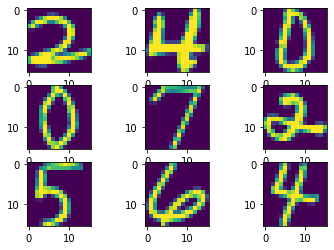

In [63]:
print("Examples from the Training Set")
fig, axs = plt.subplots(3,3)
ix = torch.randint(0, Xtr.shape[0], (9, ))
i = 0
for row in axs: 
    for col in row: 
        col.imshow(Xtr[ix[i]].squeeze())
        i += 1

In [195]:
 # Create Layer, BatchNorm, Tanh classes

# ------------------------------------------------------------------------------
class Linear: 
    def __init__(self, fanin, fanout, bias=False):
        self.weight = torch.randn([fanin, fanout]) / (fanin**0.5)
        self.bias = torch.zeros(fanout) if bias else None
    
    def __repr__(self):
        return f"Linear({tuple(self.weight.shape)})"
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None: 
            return self.out + self.bias
        else: 
            return self.out
        
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# ------------------------------------------------------------------------------
class BatchNorm1d: 
    def __init__(self, dim, momentum=0.1, tol=1e-5, training=True):
        # dim is the number of examples used in the batch 
        self.momentum = momentum 
        self.training = training
        self.dim = dim 
        self.tol = tol
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim) 
    
    def __repr__(self):
        return f"BatchNorm1d[({self.dim}, {self.momentum}) | {self.training}]"
    
    def __call__(self, x): 
        if self.training: 
            if x.ndim == 2: 
                dim = 0
            elif x.ndim == 3: 
                dim = (0, 1)
            xmean = x.mean(dim, keepdims=True)
            xvar = x.var(dim, keepdims=True, correction=1) # bessel's correction 
            self.out = self.gamma * (x - xmean) * (xvar + self.tol) ** (-0.5) + self.beta
            with torch.no_grad(): 
                self.running_mean = self.momentum * xmean + (1-self.momentum) * self.running_mean
                self.running_var = self.momentum * xvar + (1-self.momentum) * self.running_var
            
        else: 
            self.out = self.gamma * (x - self.running_mean) * (self.running_var + self.tol) ** (-0.5) + self.beta
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

# ------------------------------------------------------------------------------
class Tanh:
    def __repr__(self):
        return f"Tanh"
    
    def __call__(self, x): 
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
    
# ------------------------------------------------------------------------------
class Conv2d: 
    def __init__(self, channels_in, channels_out, kernel_size, stride, padding, bias=True): 
        self.channels_in = channels_in
        self.channels_out = channels_out
        self.kernel_size = kernel_size
        self.padding = padding
        if isinstance(self.padding, int): 
            self.padding = (padding, padding)   # symmetrical padding is required 
        self.stride = stride
        if isinstance(self.stride, int): 
            self.stride = (stride, stride)
        if isinstance(self.kernel_size, int): 
            self.kernel_size = (kernel_size, kernel_size)
        
        fanin = channels_in * math.prod(kernel_size)
        self.weight = torch.randn(channels_out, self.kernel_size[0] * self.kernel_size[1] * channels_in) / (fanin)**0.5
        self.bias = torch.randn(channels_out, 1, 1) / (fanin)**0.5 if bias else None
        
    def __repr__(self):
        return f"Conv2d({self.channels_in}ch_in, {self.channels_out}ch_out, {self.kernel_size} kernel_size, {self.stride} stride, {self.padding} padding)"
    
    @property
    def bias(self):
        return self._bias
    
    @bias.setter
    def bias(self, bias): 
        assert len(bias) == self.channels_out
        self._bias = bias.view(self.channels_out, 1, 1)
    
    def __call__(self, x):
        batch_size = x.shape[0]
        out_shape_width = (x.shape[-1] + (2*self.padding[1]) - self.kernel_size[1])/(self.stride[1]) + 1
        out_shape_height = (x.shape[-2] + (2*self.padding[0]) - self.kernel_size[0])/(self.stride[0]) + 1
        
        assert out_shape_width.is_integer(), "Combination of input volume, kernel_size, padding, and stride not acceptable in width dimension"
        assert out_shape_height.is_integer(), "Combination of input volume, kernel_size, padding, and stride not acceptable in height dimension"
        
        out_shape_width = int(out_shape_width)
        out_shape_height = int(out_shape_height)
        
        input_col = self.im2col(x)
        weights_row = self.weight.view(self.channels_out, self.kernel_size[0] * self.kernel_size[1] * self.channels_in)
#         print(f"input_col output {tuple(input_col.shape)}:")
#         print(f"x={x}")
#         print(f"input_col = {input_col.T}")
#         print(f"weights_row matrix {tuple(weights_row.shape)}:")
#         print(f"self.weight = {self.weight}")
#         print(f"weights_row = {weights_row}")
        self.out = (weights_row @ input_col.T)
        self.out = self.out.permute(*torch.arange(self.out.ndim - 1, -1, -1))    # reverse the shape so that the resulting view operation produces correct result
        self.out = self.out.view(batch_size, self.channels_out, out_shape_height, out_shape_width)
        self.out = self.out + self.bias if self.bias is not None else self.out
        return self.out
        
    def im2col(self, x):
        """
        Our own version of im2col to make efficient conv2d.
        Input: input tensor to unfold 
        Output: 3D tensor (N, C, L) where N is batch size, C is channels_in * self.kernel_size[0] * self.kernel_size[1], and L is how many blocks exist while sliding over a single input slice 
        """
        unfold = torch.nn.Unfold(self.kernel_size, 1, self.padding, self.stride)
        output = unfold(x)
        return output
        
    def parameters(self): 
        return [self.weight] + ([] if self.bias is None else [self.bias])

# ------------------------------------------------------------------------------
class MaxPool2d:
    def __init__(self, kernel_size, stride, padding): 
        self.kernel_size = kernel_size
        if isinstance(stride, int): 
            self.stride = (stride, stride)
        if isinstance(padding, int): 
            self.padding = (padding, padding)
    
    def __repr__(self): 
        return f"Pooling(kernel_size = {self.kernel_size}, stride = {self.stride}, padding = {self.padding})"
    
    def __call__(self, x): 
        x_pad = F.pad(x, self.padding)
        pools = []
        
        size_x = (x_pad.shape[-1] + 2 * self.padding[1] - self.kernel_size[1])/(self.stride[1]) + 1
        size_y = (x_pad.shape[-2] + 2 * self.padding[0] - self.kernel_size[0])/(self.stride[0]) + 1
        
        assert size_x.is_integer(), "Combination of kernel_size, stride, and padding is invalid for pooling width"
        assert size_y.is_integer(), "Combination of kernel_size, stride, and padding is invalid for pooling height"
        
        size_x = int(size_x)
        size_y = int(size_y)
        
        self.out = torch.zeros(x.shape[0], x.shape[1], size_y, size_x)
        
        for a in range(self.out.shape[0]):
            for b in range(self.out.shape[1]):
                for c in range(size_y):
                    for d in range (size_x): 
                        pool = x_pad[a, b, c * kernel_size[0] : (c+1) * kernel_size[0], d*kernel_size[1] : (d+1) * kernel_size[1]]
                        self.out[a,b,c,d] = torch.max(pool)
        
        return self.out
    
    def parameters(self): 
        return []
    
    
# ------------------------------------------------------------------------------
class Embedding: 
    def __init__(self, num_embedding, dim_embedding): 
        self.weight = torch.randn([num_embedding, dim_embedding])
    
    def __repr__(self):
        return f"Embedding({tuple(self.weight.shape)})"
    
    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
# ------------------------------------------------------------------------------
class Flatten: 
    """
    Flattens the input matrix outside of the batch dimension (first dimension)
    """
    def __call__(self, x): 
        self.out = x.reshape(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []
    
    def __repr__(self):
        return f"Flatten()"

# ------------------------------------------------------------------------------
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x): 
        B, T, C = x.shape
        x = x.view(B, T//self.n, self.n*C)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x 
        return self.out
    
    def parameters(self):
        return []
    
    def __repr__(self):
        return f"FlattenConsecutive({self.n})"
    
# ------------------------------------------------------------------------------
class Sequential: 
    def __init__(self, layers): 
        self.layers = layers
    
    def __call__(self, x):
        for layer in self.layers: 
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        # return parameters for all parameters in each layer
        return [p for layer in self.layers for p in layer.parameters()]
    
    def __repr__(self):
        return f"Sequential({self.layers})"
    
    def append(self, layer): 
        self.layers.append(layer)

In [183]:
# Test Conv2d Class
batch_size = 1
channels_in = 2
channels_out = 2
input_vol_temp = torch.tensor(np.linspace(1,16,16),  dtype=torch.float).view(1, 1, 4, 4)
input_vol = torch.zeros(1,channels_in,4,4)
input_vol[0, 0,:] = input_vol_temp
input_vol[0, 1,:] = -input_vol_temp
kernel = torch.randn(channels_out,channels_in,2,2)
bias = torch.randn(channels_out)
# kernel = torch.tensor([[1.0,2.0],[3.0,4.0]], dtype=torch.float)
# kernel = torch.tensor([[[1.0,2.0],[3.0,4.0]], [[-1.0,-2.0],[-3.0,-4.0]]], dtype=torch.float)
kernel = kernel.view(channels_out, channels_in, 2, 2)
padding = 0
stride = 1

conv2d_torch = torch.nn.Conv2d(channels_in, channels_out, kernel.shape[-2:], stride=stride, padding=padding, bias=True)
conv2d_torch.weight = torch.nn.Parameter(kernel)
conv2d_torch.bias = torch.nn.Parameter(bias)
conv2d_custom = Conv2d(channels_in, channels_out, kernel.shape[-2:], stride, padding, True)
conv2d_custom.weight = kernel
conv2d_custom.bias = bias

# print(input_vol)
# print(kernel)

output_torch = conv2d_torch(input_vol)
output_custom = conv2d_custom(input_vol)
print(output_torch)
print(output_custom)
print(torch.allclose(output_torch, output_custom))

print(output_torch.shape)
print(output_custom.shape)

tensor([[[[ -5.7869,  -6.8672,  -7.9474],
          [-10.1079, -11.1881, -12.2684],
          [-14.4288, -15.5091, -16.5893]],

         [[  2.6241,   2.9829,   3.3416],
          [  4.0591,   4.4179,   4.7766],
          [  5.4941,   5.8529,   6.2116]]]], grad_fn=<ConvolutionBackward0>)
tensor([[[[ -5.7869,  -6.8672,  -7.9474],
          [-10.1079, -11.1881, -12.2684],
          [-14.4288, -15.5091, -16.5893]],

         [[  2.6241,   2.9829,   3.3416],
          [  4.0591,   4.4179,   4.7766],
          [  5.4941,   5.8529,   6.2116]]]])
True
torch.Size([1, 2, 3, 3])
torch.Size([1, 2, 3, 3])


In [196]:
# Test MaxPool2d class
stride = 2
padding = 0
kernel_size = (2, 2)
test = torch.randn(1, 1, 4, 4)

maxpool2d_custom = MaxPool2d(kernel_size, stride, padding)
output_custom = maxpool2d_custom(test)
maxpool2d_torch = torch.nn.MaxPool2d(kernel_size, stride, padding)
output_torch = maxpool2d_torch(test)

print(test)
print(output_custom)
print(output_torch)
print(torch.allclose(output_torch, output_custom))

tensor([[[[-0.3042, -0.4876,  1.5374, -0.3716],
          [-1.1112, -0.3590, -0.4527,  0.2870],
          [ 1.8273, -0.1763, -0.1464,  1.8674],
          [ 1.1164,  2.5324, -0.9529,  0.8656]]]])
tensor([[[[-0.3042,  1.5374],
          [ 2.5324,  1.8674]]]])
tensor([[[[-0.3042,  1.5374],
          [ 2.5324,  1.8674]]]])
True


In [66]:
def get_output_vol(input_vol_dims, kernel_size, stride, padding): 
    if isinstance(padding, int): 
        padding = (padding, padding)   # symmetrical padding is required 
    if isinstance(stride, int): 
        stride = (stride, stride)
        
    output_width = (input_vol_dims[0] + 2 * padding[0] - kernel_size[0])/stride[0] + 1
    output_height = (input_vol_dims[1] + 2 * padding[1] - kernel_size[1])/stride[1] + 1
    assert output_width.is_integer(), "Dimensions of input volume, stride, kernel, and padding do not produce an integer output in width"
    assert output_height.is_integer(), "Dimensions of input volume, stride, kernel, and padding do not produce an integer output in height"
    
    return (int(output_width), int(output_height))
    

In [230]:
# Implement training of the network
# Input Layer: (1x16x16)
# Conv1 Layer: (12x16x16) Layer -> 1x12x(5x5) kernel, stride = 1, padding = 2 --> 12*16*16 = 3072 hidden units, 12x(5x5) + 12 = 312 parameters, 3072 * (1 * 5 * 5 + 1) = 79,872 connections 
# Conv2 Layer: (12x8x8) Layer -> 12x12x(5x5) kernel, stride = 1, padding = 2 --> 12*16*16 = 3072 hidden units, 12*12x5x5 + 12 = 3,612 parameters, 3072 * (12 * 5 * 5 + 1) = 924,672 connections
# MaxPool2d Layer: 2x2 kernel, stride = 2, padding = 0 --> 12 * 8 * 8 = 768 hidden units 
# FC1 Layer: 30 hidden units --> 12*8*8*30 = 23,040 parameters and links 
# FC2 layer: 10 hidden units -> classification layer --> 30 * 10 + 10 = 310 parameters and links 
# 
# Total Connections = 1,097,044
# Total Activations = 6,184 -> 6184 * 4 Bytes (float32) = 24 kB
# Total Parameters = 96,556 -> 96556 * 4 Bytes (float32) = 377 kB

# Implement network architecture
# ----------- Input Layer ----------- #
input_channels_in = 1
input_dims = (16, 16)

# ----------- Conv1 Layer ----------- #
conv1_kernel_size = (5, 5)
conv1_padding = 2
conv1_stride = 1
conv1_channels_in = 1
conv1_channels_out = 12
conv1_output_vol = get_output_vol(input_dims, conv1_kernel_size, conv1_stride, conv1_padding)

# ----------- Conv2 Layer ----------- #
conv2_kernel_size = (5, 5)
conv2_padding = 2
conv2_stride = 1
conv2_channels_in = 12
conv2_channels_out = 12
conv2_output_vol = get_output_vol(conv1_output_vol, conv2_kernel_size, conv2_stride, conv2_padding)

# ---------- MaxPool2 Layer --------- # 
maxpool1_kernel_size = (2, 2)
maxpool1_padding = 0
maxpool1_stride = 2
maxpool1_output_vol = get_output_vol(conv2_output_vol, maxpool1_kernel_size, maxpool1_stride, maxpool1_padding)

# ----------- FC1 Layer ----------- #
n_hidden1 = 30

# ----------- FC2 Layer ----------- #
n_hidden2 = 10

# ----------- Other hyperparameters ----------- #
batch_size = 32
maximum_steps = 2000

# Create model architecture
model = Sequential([
    Conv2d(conv1_channels_in, conv1_channels_out, conv1_kernel_size, conv1_stride, conv1_padding, True), Tanh(),
    Conv2d(conv2_channels_in, conv2_channels_out, conv2_kernel_size, conv2_stride, conv2_padding, True), Tanh(),
    torch.nn.MaxPool2d(maxpool1_kernel_size, maxpool1_stride, maxpool1_padding),
    Flatten(), Linear(fanin=conv2_channels_out * maxpool1_output_vol[0] * maxpool1_output_vol[1], fanout=n_hidden1, bias=False), BatchNorm1d(dim=n_hidden1), Tanh(),
    Linear(fanin=n_hidden1, fanout=n_hidden2, bias=True)
])
params = model.parameters()
print(f"Conv1 Parameters = {sum([torch.numel(p) for p in model.layers[0].parameters()])}")
print(f"Conv2 Parameters = {sum([torch.numel(p) for p in model.layers[2].parameters()])}")
print(f"FC1 Parameters = {sum([torch.numel(p) for p in model.layers[6].parameters()])}")
print(f"FC2 parameters = {sum([torch.numel(p) for p in model.layers[9].parameters()])}")
print("-------")
print(f"Total Parameters = {sum([torch.numel(p) for p in params])}")

# Require grad on parameters and set batchnorm layer to training
for p in params: 
    p.requires_grad = True
for layer in model.layers: 
    layer.training = True

losses = []
for i in range(maximum_steps): 
    
    # create mini-batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    x = Xtr[ix]
    y = Ytr[ix]
    
    # forward pass
    logits = model(x)
    lossi = F.cross_entropy(logits, y)
    
    # backward pass 
#     for layer in model.layers: 
#         layer.out.retain_grad()
    for p in params: 
        p.grad = None
    lossi.backward()
    
    # update 
    lr = 0.1 if i < 1000 else 0.01
    for p in params: 
        p.data -= lr * p.grad
    
    # track loss statistics
    if i % 100 == 0: 
        print(f"step {i}/{maximum_steps}: loss = {lossi}")
    losses.append(lossi.data)
    
#     if i < 2: 
#         break 

Conv1 Parameters = 312
Conv2 Parameters = 3612
FC1 Parameters = 23040
FC2 parameters = 310
-------
Total Parameters = 27334
step 0/2000: loss = 2.6507105827331543
step 100/2000: loss = 0.24234949052333832
step 200/2000: loss = 0.33899828791618347
step 300/2000: loss = 0.07823152840137482
step 400/2000: loss = 0.06011519208550453
step 500/2000: loss = 0.04176761209964752
step 600/2000: loss = 0.05389133840799332
step 700/2000: loss = 0.05103294178843498
step 800/2000: loss = 0.03600037097930908
step 900/2000: loss = 0.05847504734992981
step 1000/2000: loss = 0.011911035515367985
step 1100/2000: loss = 0.025788037106394768
step 1200/2000: loss = 0.10322200506925583
step 1300/2000: loss = 0.01268854085355997
step 1400/2000: loss = 0.04250943660736084
step 1500/2000: loss = 0.055995408445596695
step 1600/2000: loss = 0.0193550493568182
step 1700/2000: loss = 0.06975571066141129
step 1800/2000: loss = 0.05571058765053749
step 1900/2000: loss = 0.018178466707468033


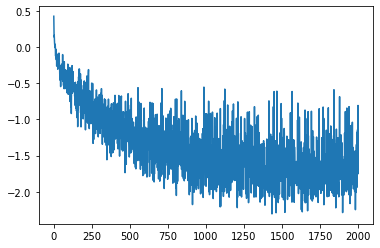

In [231]:
plt.plot(np.log10(losses))

In [232]:
# measure train vs. test set 

# first set BatchNorm to run-mode
for layer in model.layers: 
    layer.training = False

def split_loss(split): 
    X, Y = {
        'train': (Xtr, Ytr),
        'test': (Xte, Yte)
    }[split]
    
    # forward pass
    logits = model(X) 
    loss = F.cross_entropy(logits, Y)
    
    return loss 

print(f"Training Loss = {split_loss('train')}")
print(f"Test Loss = {split_loss('test')}")

Training Loss = 0.01957547850906849
Test Loss = 0.1335938423871994


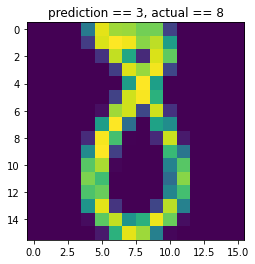

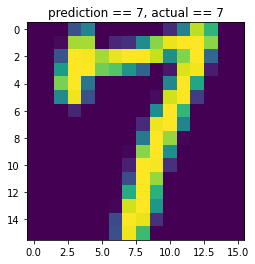

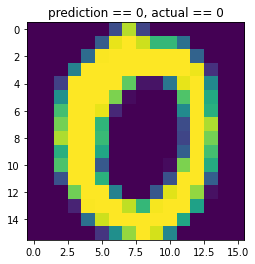

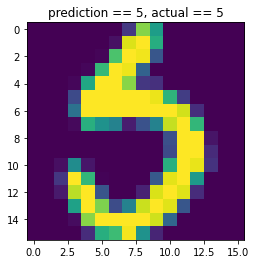

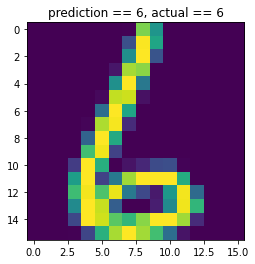

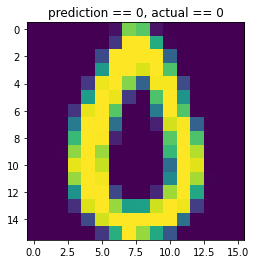

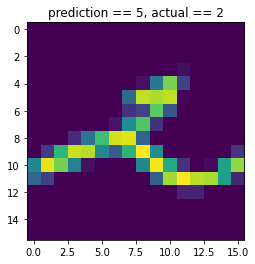

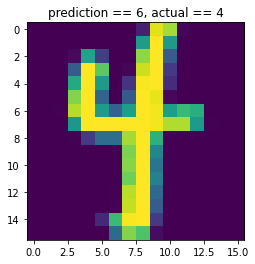

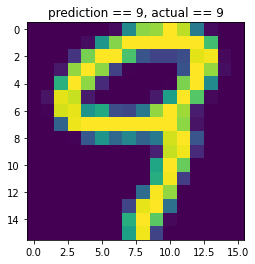

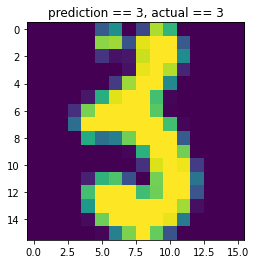

In [234]:
# first set BatchNorm to run-mode
for layer in model.layers: 
    layer.training = False

for i in range(10):
    # sample the model 
    ix = torch.randint(0, Xte.shape[0], (1, ))
    x = Xte[ix]
    y = Yte[ix]

    logits = model(x)
    probs = logits.exp()
    select = torch.multinomial(probs, 1).item()

    plt.figure()
    plt.imshow(x.squeeze())
    plt.title(f"prediction == {select}, actual == {y.item()}")
